<a href="https://colab.research.google.com/github/LorenaMueller/refine_DCG_outlines/blob/master/Visualize_input_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


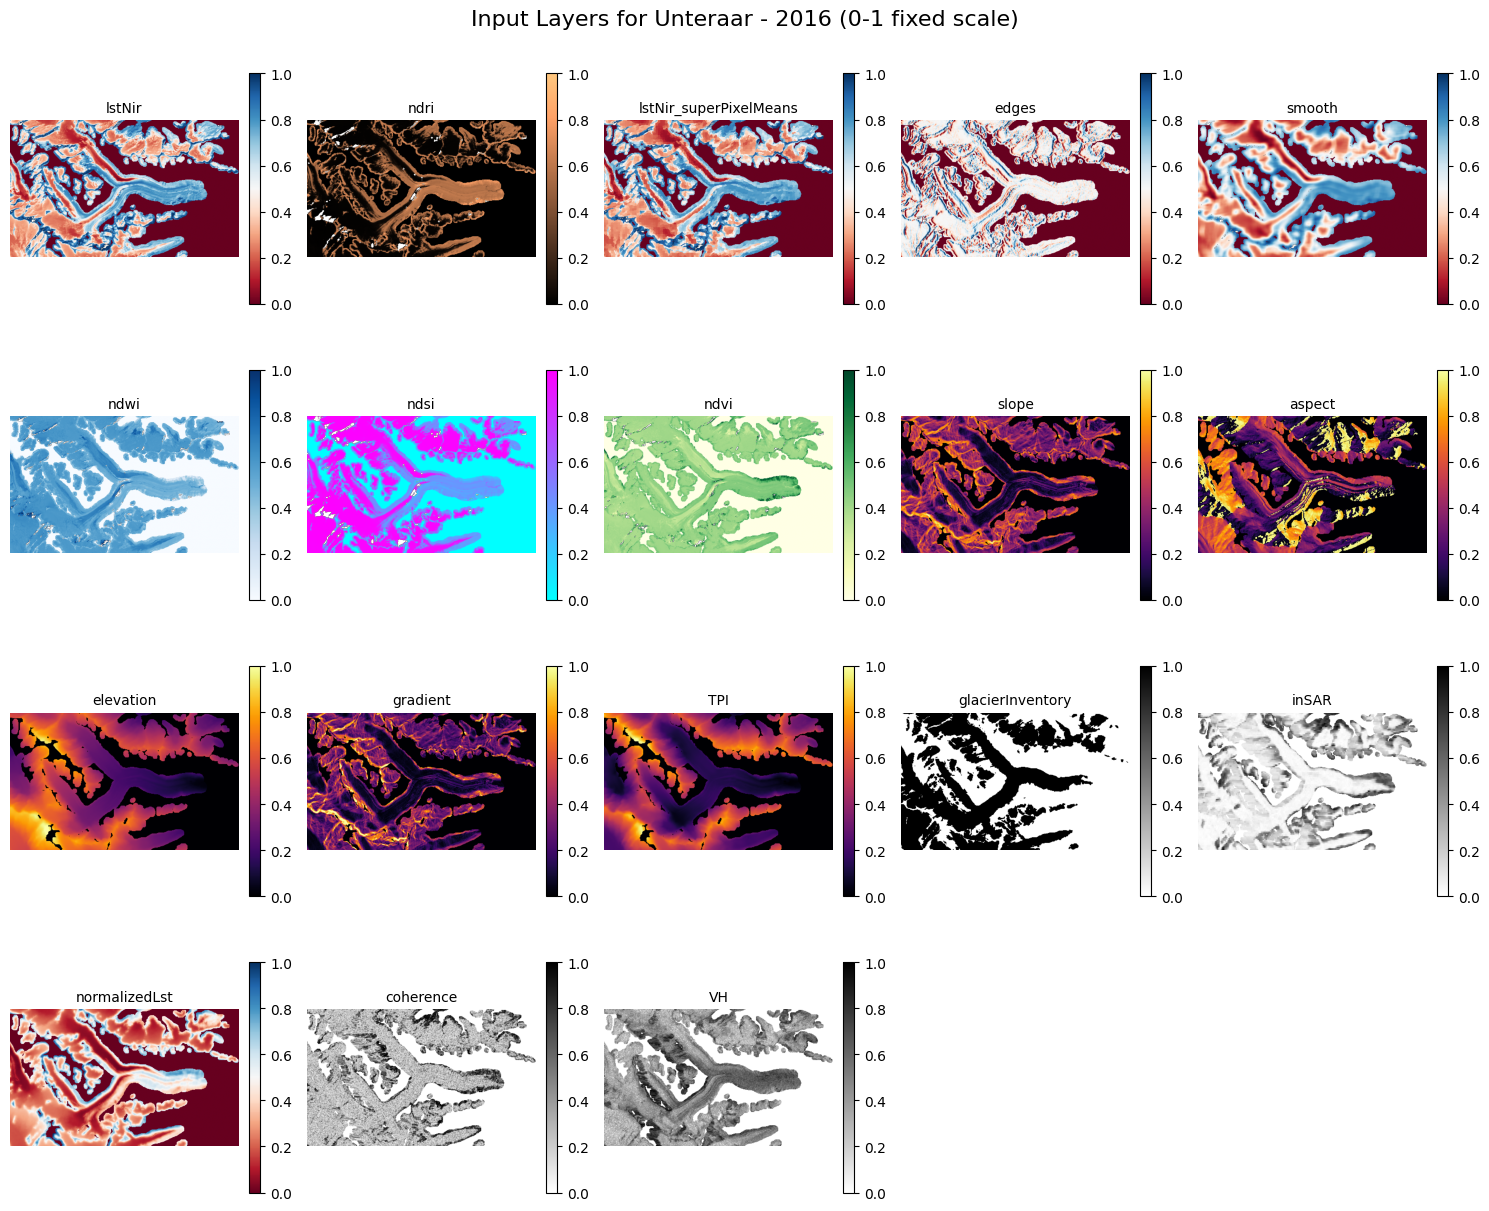

In [5]:
# Visualize input layers for a glacier and year of inetrest

import os
import ee
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from skimage import measure
from matplotlib.patches import Patch
from matplotlib import cm

#===========================
glacier_to_plot = "unteraar"
year_to_plot = 2016
#===========================

train_year = 2016  # Always using 2016 for training
train_glaciers = ['oberaletsch', 'zmutt']  # Glaciers used for training
test_glacier = 'unteraar'  # Glacier to test on
test_year = [2016, 2018, 2020, 2022] # Year to test on (can be modified)

# ==============================================================================
# Part I
# ==============================================================================

# Mount Google Drive (for Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Paths to images stored in Google Drive
glaciers = ['zmutt', 'unteraar', 'belvedere', 'oberaletsch']
years = [2016, 2018, 2020, 2022]

# Generate dynamic paths for all glaciers and years
image_paths = {}
for glacier in glaciers:
    image_paths[glacier] = {}
    for year in years:
        image_paths[glacier][year] = f"/content/drive/My Drive/GEE_Exports_input_layers_DCG/{glacier}_{year}_layers_drive.tif"


def read_raster(image_path):
    dataset = gdal.Open(image_path, gdal.GA_ReadOnly)
    if dataset is None:
        raise ValueError(f"Failed to open {image_path}. Check if the file exists and is readable.")
    image_array = dataset.ReadAsArray()
    return np.array(image_array)  # Ensure it's a NumPy array


# Load images directly from Google Drive
original_image_data = {}
for glacier in glaciers:
    original_image_data[glacier] = {}
    for year in years:
        original_image_data[glacier][year] = read_raster(image_paths[glacier][year])

# Assuming ground truth labels are stored separately, load them
labels_path = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/zmutt_labels.tif",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/unteraar_labels.tif",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/belvedere_labels.tif",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/oberaletsch_labels.tif"
}

original_label_data = {}
for key, path in labels_path.items():
    with rasterio.open(path) as src:
        original_label_data[key] = src.read(1)  # Assuming single-band label

# Paths to shapefiles stored in Google Drive
buffers_paths = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_zmutt.shp",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_unteraar.shp",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_oberaletsch.shp",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_belvedere.shp"
}

# Load shapefiles using geopandas
buffers = {key: gpd.read_file(path) for key, path in buffers_paths.items()}

# clip images with their corresponding buffer
import rasterio
from rasterio.mask import mask

# Function to clip a raster with its corresponding buffer
def clip_raster(raster_array, raster_path, buffer_gdf):
    with rasterio.open(raster_path) as src:
        # Reproject buffer to match raster CRS
        buffer_gdf = buffer_gdf.to_crs(src.crs)

        # Convert buffer to a list of geometries
        geometries = [geom for geom in buffer_gdf.geometry]

        # Clip the raster
        clipped_image, clipped_transform = mask(src, geometries, crop=True)

        # If it's a 3D array (bands, height, width), don't select [0] blindly
        if clipped_image.ndim == 3:  # Multi-band image
            clipped_image = np.moveaxis(clipped_image, 0, -1)  # Move bands to last axis
        elif clipped_image.ndim == 2:  # Single-band image
            clipped_image = clipped_image  # No change needed

        # Update metadata
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_image.shape[0],  # Update height
            "width": clipped_image.shape[1],   # Update width
            "transform": clipped_transform     # Update the transform
        })

    return clipped_image, clipped_meta  # Ensure clipped_image is a NumPy array

# Dictionaries to store clipped images and labels
image_data = {}
label_data = {}

for glacier in glaciers:
  image_data[glacier] = {}  # Initialize glacier-level dictionary
  label_data[glacier], _ = clip_raster(original_label_data[glacier], labels_path[glacier], buffers[glacier])


for glacier in glaciers:
  for year in years:
        # Clip the image
        image_data[glacier][year], _ = clip_raster(original_image_data[glacier][year], image_paths[glacier][year], buffers[glacier])

for glacier in glaciers:
    label_data[glacier] = {}  # Initialize dictionary for years
    for year in years:
        label_data[glacier][year], _ = clip_raster(original_label_data[glacier], labels_path[glacier], buffers[glacier])

# Only using the specified bands for training and testing
selected_bands = ['lstNir', 'ndri', 'lstNir_superPixelMeans', 'edges', 'smooth', 'ndwi', 'ndsi', 'ndvi', 'slope', 'aspect', 'elevation', 'gradient', 'TPI', 'glacierInventory', 'inSAR', 'normalizedLst', 'coherence', 'VH']
bands = selected_bands

# Mapping band names to indices in the images (these should match the band order in the images)
band_indices = {
    'lstNir': 0,
    'ndri': 1,
    'lstNir_superPixelMeans': 2,
    'edges': 3,
    'smooth': 4,
    'ndwi': 5,
    'ndsi': 6,
    'ndvi': 7,
    'slope': 8,
    'aspect': 9,
    'elevation': 10,
    'gradient': 11,
    'TPI': 12,
    'glacierInventory': 13,
    'inSAR': 14,
    'normalizedLst': 15,
    'coherence': 16,
    'VH': 17
}


# ==============================================================================
# Visualize input layers
# ==============================================================================
# Custom colormap assignments
custom_cmaps = {
    'elevation': 'inferno',
    'gradient': 'inferno',
    'aspect': 'inferno',
    'slope': 'inferno',
    'TPI': 'inferno',
    'glacierInventory': 'binary',
    'ndri': 'copper',
    'ndvi': 'YlGn',
    'ndwi': 'Blues',
    'ndsi': 'cool',
    'lstNir': 'RdBu',
    'lstNir_superPixelMeans': 'RdBu',
    'edges': 'RdBu',
    'smooth': 'RdBu',
    'normalizedLst': 'RdBu',
    'inSAR': 'binary',
    'coherence': 'binary',
    'VH': 'binary',
}

# Visualize input layers for a specific glacier and year

image = image_data[glacier_to_plot][year_to_plot]
height, width, n_bands = image.shape

n_cols = 5
n_rows = int(np.ceil(n_bands / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, (band_name, band_idx) in enumerate(band_indices.items()):
    band = image[:, :, band_idx]

    cmap = custom_cmaps.get(band_name, 'viridis')
    ax = axes[i]
    im = ax.imshow(band, cmap=cmap, vmin=0, vmax=1)
    ax.set_title(f"{band_name}", fontsize=10)
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle(f"Input Layers for {glacier_to_plot.capitalize()} - {year_to_plot} (0-1 fixed scale)", fontsize=16, y=1.02)
plt.show()

